In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pyMMF

%matplotlib inline

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rcParams.update({'font.size': MEDIUM_SIZE})
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## 1. Parameters of the fiber
Comsol simulation were done using those same parameters

In [2]:
NA = 0.2
radius = 25 # in microns
areaSize = 2.4*radius # calculate the field on an area larger than the diameter of the fiber
npoints = 2**7 # resolution of the window
n1 = 1.45
wl = 1.55 # wavelength in microns
curvature = None
k0 = 2.*np.pi/wl


r_max = 3.2*radius
npoints_search = 2**8
dh = 2*radius/npoints_search

## 2. Compute transverse modes using pyMMF

In [3]:
profile = pyMMF.IndexProfile(npoints = npoints, areaSize = areaSize)
profile.initParabolicGRIN(n1=n1,a=radius,NA=NA)

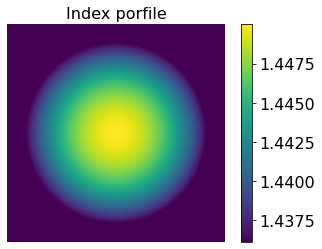

In [4]:
plt.figure()
plt.imshow(profile.n.reshape([npoints]*2))
plt.title(r'Index porfile')
plt.axis('off')
plt.colorbar()

In [ ]:
solver = pyMMF.propagationModeSolver()
solver.setIndexProfile(profile)
solver.setWL(wl)
modes = solver.solve(
        mode='radial',
        curvature = None,
        r_max = r_max, # max radius to calculate (and first try for large radial boundary condition)
        dh = dh, # radial resolution during the computation
        min_radius_bc = 1.5, # min large radial boundary condition
        change_bc_radius_step = 0.95, #change of the large radial boundary condition if fails 
        N_beta_coarse = int(1e3) # number of steps of the initial coarse scan
        )

2020-10-30 15:28:18,161 - pyMMF.core [DEBUG  ]  Debug mode ON.
2020-10-30 15:28:18,178 - pyMMF.solv [INFO   ]  Found 5 radial mode(s) for m=0
2020-10-30 15:28:18,179 - pyMMF.solv [INFO   ]  Searching propagation constant for |l| = 0
2020-10-30 15:28:18,183 - pyMMF.solv [INFO   ]  Searching propagation constant for |l| = 1
2020-10-30 15:28:18,249 - pyMMF.solv [WARNING]  maximum recursion depth exceeded
2020-10-30 15:28:18,249 - pyMMF.solv [WARNING]  Boundary condition could not be met.
2020-10-30 15:28:18,250 - pyMMF.solv [WARNING]  Retrying by changing r_max to 3.03a
2020-10-30 15:28:18,323 - pyMMF.solv [WARNING]  maximum recursion depth exceeded
2020-10-30 15:28:18,324 - pyMMF.solv [WARNING]  Boundary condition could not be met.
2020-10-30 15:28:18,324 - pyMMF.solv [WARNING]  Retrying by changing r_max to 2.88a
2020-10-30 15:28:18,392 - pyMMF.solv [WARNING]  maximum recursion depth exceeded
2020-10-30 15:28:18,392 - pyMMF.solv [WARNING]  Boundary condition could not be met.
2020-10-30

### Get the mode matrix and rearrange to mode order 
(to fit with comsol data later on)

In [ ]:
M0_as = modes.getModeMatrix(npola = 2)
Nmodes = modes.number
new_ind = [i//2 if i%2 == 0 else (i-1)//2+Nmodes for i in range(2*Nmodes)]
M0_as = M0_as[:,new_ind]
betas_as = np.sort(np.concatenate([modes.betas]*2))[::-1]

## 3. Solve using the 2D finite difference eigenvalue solver
See wavefrontshapin.net tutorial on [solving the Helmholtz discretized equation](https://www.wavefrontshaping.net/post/id/3) and on [pyMMF implementation](https://www.wavefrontshaping.net/post/id/6).

In [ ]:
modes = solver.solve(
        mode='eig',
        nmodesMax=Nmodes)

In [ ]:
M0_eig = modes.getModeMatrix(npola = 2)
M0_eig = M0_eig[:,new_ind]
betas_eig = np.abs(np.sort(np.concatenate([modes.betas]*2))[::-1])

## 4. Load Comsol data
We used the same paramters as for pyMMF calculations.
Simulation are full vectorial FDTD simulation, so we do have a 
(small) longitudinal component of the optical field. 

In [ ]:
data = np.load('modes_transverse_comsol_128.npz')
# matrix of transverse mode profiles
M0_cs = data['M0_cs']
# propagation constats 
betas_cs = data['betas']

### Show one mode

In [ ]:
ind = 50

Ex = M0_cs[:npoints**2,ind].reshape([npoints]*2)
Ey = M0_cs[npoints**2:2*npoints**2,ind].reshape([npoints]*2)
Ez = M0_cs[2*npoints**2:,ind].reshape([npoints]*2)

max_E = np.max([np.max(np.abs(E)) for E in [Ex,Ey]])

plt.figure(figsize=[12,5])
plt.subplot(131)
plt.imshow(np.abs(Ex), vmax = max_E)
plt.axis('off')
plt.title(r'$|E_x|$')
plt.subplot(132)
plt.imshow(np.abs(Ey), vmax = max_E)
plt.axis('off')
plt.title(r'$|E_y|$')
plt.subplot(133)
plt.imshow(np.abs(Ez), vmax = max_E)
plt.axis('off')
plt.title(r'$|E_z|$')
plt.suptitle(f'Full vectorial FDTD (Comsol)\n Mode {ind}')

plt.figure(figsize=[8,5])
plt.subplot(121)
plt.imshow(np.sqrt(np.abs(Ex)**2+np.abs(Ey)**2), vmax = max_E)
plt.axis('off')
plt.title(r'$|E_t|$')
plt.subplot(122)
plt.imshow(np.abs(Ey), vmax = max_E)
plt.axis('off')
plt.title(r'$|E_y|$')
plt.suptitle(f'Full vectorial FDTD (Comsol)\n Mode {ind}')

## 4. Compare propagation constants

### 4.1 Whole range

In [ ]:
msize = 14
beta_max = k0*n1
beta_min = k0*np.min(profile.n)
plt.figure(figsize = (10,6))
plt.plot(betas_cs[:110],'b+', label = 'Comsol')
plt.plot(betas_as,'r*', label = 'pyMMF axisymmetric solver')
plt.plot(betas_eig,'gx', label = 'pyMMF axisymmetric solver')
plt.axhline(beta_min, color='g')
plt.axhline(beta_max, color='g')
plt.xlabel('Modes')
plt.ylabel('Propagation constant')
plt.ylim([5.81,5.88])
plt.legend(fontsize=16, loc = 'upper right')

## Show a mode


### 4.2 Zoom on lower order modes

In [ ]:
xlim = [0,10]
ylim = [5.86,5.875]
beta_max = k0*n1
beta_min = k0*np.min(profile.n)
plt.figure(figsize = (10,6))
plt.plot(np.abs(betas_cs[:110]),'b+', label = 'Comsol', markersize = msize)
plt.plot(betas_as,'r*', label = 'pyMMF axisymmetric solver', markersize = msize, markeredgewidth=2)
plt.plot(betas_eig,'gx', label = 'pyMMF axisymmetric solver', markersize = msize, markeredgewidth=2)
plt.axhline(beta_min, color='g')
plt.axhline(beta_max, color='g')
plt.xlabel('Modes')
plt.ylabel('Propagation constant')
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend(fontsize=16, loc = 'upper right')

### 4.3 Zoom on higher order modes

In [ ]:
xlim = [89,110]
ylim = [5.8215,5.824]
beta_max = k0*n1
beta_min = k0*np.min(profile.n)
plt.figure(figsize = (10,6))
plt.plot(betas_cs[:110],'b+', label = 'Comsol', markersize = msize)
plt.plot(betas_as,'r*', label = 'pyMMF axisymmetric solver', markersize = msize, markeredgewidth=2)
plt.plot(betas_eig,'gx', label = 'pyMMF axisymmetric solver', markersize = msize, markeredgewidth=2)
plt.axhline(beta_min, color='g')
plt.axhline(beta_max, color='g')
plt.xlabel('Modes')
plt.ylabel('Propagation constant')
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend(fontsize=16, loc = 'upper right')

In [ ]:
i = 4
ex = M0_cs[:npoints**2,i].reshape([npoints]*2)
ey = M0_cs[npoints**2:2*npoints**2,i].reshape([npoints]*2)
ex2 = M0_as[:npoints**2,i].reshape([npoints]*2)
ey2 = M0_as[npoints**2:,i].reshape([npoints]*2)

m = np.max([np.max(np.abs(ex)),np.max(np.abs(ey))])
m2 = np.max([np.max(np.abs(ex2)),np.max(np.abs(ey2))])
plt.figure(figsize=(9,9))
plt.subplot(221)
plt.imshow(np.abs(ex), vmax = m)
plt.axis('off')
plt.title(r'$|E_x|$')
plt.subplot(222)
plt.imshow(np.abs(ey), vmax = m)
plt.axis('off')
plt.title(r'$|E_y|$')
plt.subplot(223)
plt.imshow(np.abs(ex2), vmax = m2)
plt.axis('off')
plt.subplot(224)
plt.imshow(np.abs(ey2), vmax = m2)
plt.axis('off')

## 5. Projection of one basis onto the other one
#### The order **inside** each degenerate group is not exacty the same, but it is normal as they are degenerate.

In [ ]:
# only keep transverse field
M0_cs_trans = M0_cs[:2*npoints**2,:110]

### 5.1 Display conversion matrices

In [ ]:
A_as = M0_cs_trans.transpose().conjugate()@M0_as
A_eig = M0_cs_trans.transpose().conjugate()@M0_eig
plt.figure(figsize = (12,7))
plt.subplot(121)
plt.imshow(np.abs(A_as), interpolation = 'None')
plt.axis('off')
plt.title('axisymmetric solver VS Comsol')
plt.subplot(122)
plt.imshow(np.abs(A_eig), interpolation = 'None')
plt.axis('off')
plt.title('2D eigenvalue solver VS Comsol')

### 5.2 Check for conversion losses

We compute the singular value decomposition of the conversion matrix between the modes found using Comsol
and using the pyMMF solvers $M_\text{cs}^\dagger . M_\text{pyMMF}$. 
Ideally, if two bases represent the same subspace, the conversion matrix has to be unitary, 
i.e. all its singular values are equal to one.

In [ ]:
_,s_as,_ = np.linalg.svd(A_as)
_,s_eig,_ = np.linalg.svd(A_eig)
plt.figure(figsize = (10,6))
plt.plot(np.sort(np.real(s_as)), label = 'axisymmetric solver')
plt.plot(np.sort(np.real(s_eig)), label = '2D eigenvalue solver')
plt.ylim([0.5, 1.1])
plt.legend()
plt.title('Singular values of conversion matrices')